## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Setting the seed to assure we get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
(df.converted == 1).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[((df.group == 'treatment') & (df.landing_page != 'new_page')) | ((df.group != 'treatment') & (df.landing_page == 'new_page'))].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
delete = (df[((df.group == 'treatment') & (df.landing_page != 'new_page')) | ((df.group != 'treatment') & (df.landing_page == 'new_page'))]).index
delete

Int64Index([    22,    240,    308,    327,    357,    490,    685,    713,
               776,    846,
            ...
            293817, 293888, 293894, 293917, 293996, 294014, 294200, 294252,
            294253, 294331],
           dtype='int64', length=3893)

In [9]:
df2 = df.drop(delete)
df2.shape

(290585, 5)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(2893, inplace = True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
(df2['converted'] == 1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
(df2.query('group == "control"')['converted'] == 1).mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
(df2.query('group == "treatment"')['converted'] == 1).mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**Answer**<br>
There is no sufficient evidence that treatment page leads to more conversions as the probability of conversion for treatment group is less than that for control group just by a tiny margin.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Hypothesis**<br>
$H_{0}$ : $p_{old}$ >=  $p_{new}$ <br>
$H_{1}$ : $p_{old}$ <  $p_{new}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null?

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

-0.0005593670054385713

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [26]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
    p_diff = new_page_converted.mean()-old_page_converted.mean()
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

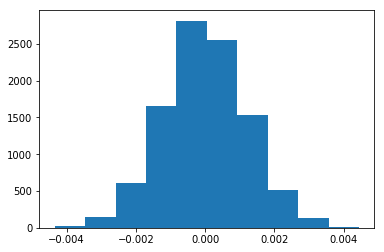

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
act_diff = (df2.query('group == "treatment"')['converted'] == 1).mean() - (df2.query('group == "control"')['converted'] == 1).mean()
(p_diffs > act_diff).mean()

0.9068

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**<br>
We calculated the p-value here as 0.9053. This is the probability of observing our statistic(or one more extreme in favour of the alternative) if the null hypothesis is true.<br>
This is far greater than the typical $\alpha$ level of 0.05 in business studies. An $\alpha$ level of 0.05 indicates that we have a 5% chance of committing a Type I error if the null is true.<br>
We find that there is no coversion advantage with new pages. So, we conclude that there is not sufficient evidence to say that there is a difference between the two values.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = sum(df2.query('group == "control"')['converted'])
convert_new = sum(df2.query('group == "treatment"')['converted'])
n_old = len(df2.query('group == "control"'))
n_new = len(df2.query('group == "treatment"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [31]:
from scipy.stats import norm
# Tells us how significant our z-score is
print(norm.cdf(z_score))

# for our single-sides test, assumed at 95% confidence level, calculate critical value at 95% confidence: 
print(norm.ppf(1-(0.05)))

0.9050583127590245
1.6448536269514722


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**<br>
Since the z-score is less than the critical value, we fail to reject the null hypothesis. This suggests that new page conversion rate is higher than that of old page and yes, these values agree with the findings in the parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer**<br>
Since this is a Yes-No type of variable, the appropriate approach is Logistic Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [32]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [33]:
# Create dummy variables and add an intercept
df2[['ab_page','control']] = pd.get_dummies(df2['group'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,control,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [34]:
import statsmodels.api as sm

logit = sm.Logit(df2['converted'],df2[['intercept' ,'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Mar 2019   Pseudo R-squ.:               8.077e-06
Time:                        21:19:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer**<br>
The p-value associated with ab_page is 0.190.

It differs from what we found in Part II because this was two sided test and in Part II it was one sided test.Here we test for not equal in our hypotheses there it was greater than or equal.

$$ H_0: p_{new} = p_{old} $$$$ H_1: p_{new} \neq p_{old} $$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer**<br>
Things like which program people apply for or age or gender of user might influence whether or not an individual converts to new page.
Trend appears in several different groups of data but disappears or reverses when these groups are combined (Simpson's paradox).

Yes, if we add high correlations predictor variables, leading to unreliable and unstable estimates of regression coefficients (Multicollinearity) can affect our model.Every time we include a new predictor variable with no change in sample size we lose a degree of freedom. The result often is that previously significant predictor in the new regression is no long significant at the same probability of a Type 1 error (the significance level).

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [36]:
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
df3 = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,ab_page,control,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1


In [38]:
df3['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [39]:
# Create necessary dummy variables
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3.head()

,country,timestamp,group,landing_page,converted,ab_page,control,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there are significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [40]:
log = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'US']])
results = log.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 11 Mar 2019   Pseudo R-squ.:               1.521e-05
Time:                        21:19:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

The p-values for the countries are well above a 0.05 $\alpha$ level. So we once again fail to reject the null and conclude that on it's own, there is no significant contribution from country to differences in conversion rates for the two pages.

Now we would look at an interaction between page and country to see if there are significant effects on conversion.

In [41]:
df3['CA_page'] = df3['CA'] * df3['ab_page']
df3['US_page'] = df3['US'] * df3['ab_page']
df3.head()

,country,timestamp,group,landing_page,converted,ab_page,control,intercept,CA,UK,US,CA_page,US_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1,0,0,0


In [42]:
log = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'US', 'CA_page', 'US_page']])
results = log.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 11 Mar 2019   Pseudo R-squ.:               3.482e-05
Time:                        21:19:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9814      0.016   -122.860      0.000      -2.013      -1.950
ab_page       -0.0108      0.023     -0.475      0.635      -0.056       0.034
CA            -0.0901      0.040     -2.225      0.026      -0.169      -0.011
US            -0.0257      0.019     -1.363      0.173      -0.063       0.011
CA_page        0.0783      0.057      1.378      0.168      -0.033       0.190
US_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

None of the variables have significant p-values.

In [43]:
np.exp(results.params)

intercept    0.137878
ab_page      0.989224
CA           0.913871
US           0.974672
CA_page      1.081428
US_page      1.031896
dtype: float64

In [44]:
df.groupby('group').mean()['converted']

group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64

#### Conclusions from Part III:

In this logistic regression model too, we find that the values do not show a substantial difference in the conversion rates for control group and treatment group. This indicates that we can accept the null hypothesis and keep the existing page as it is.

## Conclusions

* The performance of the old page was found better (though by miniscule values only) as computed by different techniques.
* So, we accept the null hypothesis and reject the alternate hypothesis.
* These inferences are strictly based on data on hand. This analysis acknowledges its limitations due to factors not included in the data.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0